In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
pd.read_pickle('../FelyxData/JA23Movers')

,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,distancemoved,prev_fl
669213,853,47,2023-01-02 15:06:40,52.373069,4.883232,POINT (4.88323 52.37307),2023-01-02 14:47:28,0 days 00:19:12,POINT (4.88703 52.35451),0.018946,NaN
743782,853,38,2023-01-02 18:50:40,52.358633,4.859237,POINT (4.85924 52.35863),2023-01-02 17:29:36,0 days 01:21:04,POINT (4.88286 52.37315),0.027727,47.0
997459,853,19,2023-01-03 06:36:48,52.356520,4.835737,POINT (4.83574 52.35652),2023-01-03 06:24:00,0 days 00:12:48,POINT (4.85950 52.35868),0.023861,38.0
1032883,853,16,2023-01-03 08:23:28,52.340103,4.845550,POINT (4.84555 52.34010),2023-01-03 08:04:16,0 days 00:19:12,POINT (4.83574 52.35652),0.019126,19.0
1516276,853,100,2023-01-04 07:34:24,52.352043,4.895090,POINT (4.89509 52.35204),2023-01-03 16:00:00,0 days 15:34:24,POINT (4.84540 52.34019),0.051084,16.0
...,...,...,...,...,...,...,...,...,...,...,...
12311880,8552,94,2023-04-24 11:26:56,52.377628,4.895447,POINT (4.89545 52.37763),2023-04-24 11:09:52,0 days 00:17:04,POINT (4.90533 52.36618),0.015124,96.0
12373802,8552,93,2023-04-24 14:30:24,52.356447,4.877758,POINT (4.87776 52.35645),2023-04-24 14:09:04,0 days 00:21:20,POINT (4.89539 52.37759),0.027530,94.0
12406522,8552,90,2023-04-24 16:19:12,52.369837,4.861357,POINT (4.86136 52.36984),2023-04-24 16:06:24,0 days 00:12:48,POINT (4.87779 52.35643),0.021208,93.0
12415112,8552,85,2023-04-24 16:49:04,52.330968,4.852679,POINT (4.85268 52.33097),2023-04-24 16:27:44,0 days 00:21:20,POINT (4.86099 52.36976),0.039672,90.0


In [116]:
df = pd.read_pickle('../../JA23Movers').dropna().sample(100000).reset_index().drop(['index'], axis = 1)

In [99]:
PCs = gpd.read_file('../../PublicGeoJsons/AmsPCs.json')

In [123]:
df = df.join(
    gpd.GeoDataFrame(
    df[['prev_location']],  geometry= df[['prev_location']].prev_location,
    crs='EPSG:4326'
).drop('prev_location', axis = 1).sjoin(PCs.rename(columns = {'Postcode4':'vertpc'})).vertpc
 )

ValueError: columns overlap but no suffix specified: Index(['vertpc'], dtype='object')

In [124]:
df = df.join(
    gpd.GeoDataFrame(
    df,  geometry= df.geometry,
    crs='EPSG:4326'
).sjoin(PCs.rename(columns = {'Postcode4':'aankpc'})).aankpc
 )

In [125]:
df['hour'] = df['prev_time'].dt.hour
df['weekday'] = df['prev_time'].dt.dayofweek
# df.drop(['prev_time'], axis =1, inplace = True)

In [126]:
train_cols = ['aankpc', 'hour', 'weekday', 'vertpc']

In [127]:
df['vertpc'] = df['vertpc'].astype(str)
df['aankpc'] = df['aankpc'].astype(str)
df['Real'] = [1]*len(df)

In [128]:
Real = df[train_cols]
Real['Real'] = [1]*len(Real)
Real

/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_55219/3423356893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Real['Real'] = [1]*len(Real)


,aankpc,hour,weekday,vertpc,Real
0,1105.0,21,4,1102.0,1
1,1053.0,16,2,1018.0,1
2,1012.0,12,0,1016.0,1
3,1072.0,18,3,1078.0,1
4,1055.0,23,5,1043.0,1
...,...,...,...,...,...
99995,1015.0,13,5,1011.0,1
99996,1018.0,16,1,1013.0,1
99997,1072.0,9,4,1059.0,1
99998,1017.0,15,2,1077.0,1


In [129]:
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import unary_union

In [130]:
polys = [x for x in PCs.geometry if type(x) == Polygon ]
multipolys = [x for x in PCs.geometry if type(x) == MultiPolygon]
multipolys.append(MultiPolygon(polys))
combined_multi_polygon = unary_union(multipolys)

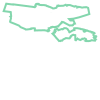

In [131]:
combined_multi_polygon.boundary

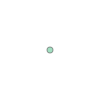

In [132]:
def samplepoint(gdf_polys):
    point = None
    while not gdf_polys.contains(point):
        # generate a random point within a bounding box that encompasses the multipolygon
        minx, miny, maxx, maxy = gdf_polys.bounds
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if gdf_polys.contains(random_point):
            point = random_point

    return point

samplepoint(combined_multi_polygon)

In [133]:
def generate_fakedf(dflen, combined_multi_polygon):
    Fake = pd.DataFrame({col: random.choices(Real[col].unique(), k = dflen)  for col in ['hour', 'weekday']})
    Fake['Real'] = [0]* dflen
    Fake['start'] = [samplepoint(combined_multi_polygon) for i in range(dflen)]
    Fake['end'] = [samplepoint(combined_multi_polygon) for i in range(dflen)]
    return Fake

In [134]:
Fake = generate_fakedf(len(Real), combined_multi_polygon)

In [135]:
Fake

,hour,weekday,Real,start,end
0,7,5,0,POINT (5.046593075922439 52.3794016742487),POINT (4.857691348628856 52.37102354456096)
1,4,2,0,POINT (4.86723455553728 52.34501941913704),POINT (5.083345819272708 52.31127652953387)
2,7,4,0,POINT (5.037463757301553 52.39920102296713),POINT (4.859419769589989 52.40236442033736)
3,0,6,0,POINT (4.8019753227453865 52.35002771517054),POINT (5.058280325287299 52.40524397342869)
4,13,6,0,POINT (4.810048325003029 52.34126172514601),POINT (4.936752366559888 52.30550757384143)
...,...,...,...,...,...
99995,14,6,0,POINT (4.8386451271108495 52.32874900316569),POINT (4.832559704247842 52.41512188479181)
99996,10,5,0,POINT (4.903250040776204 52.33311868841732),POINT (4.8015825753740655 52.34328945234186)
99997,11,1,0,POINT (4.983350820151669 52.30395783365496),POINT (4.988294844097732 52.40623443134555)
99998,13,5,0,POINT (4.993283685135054 52.41681348683676),POINT (4.761613763204412 52.36502024385731)


In [136]:
Fake = Fake.join(
    gpd.GeoDataFrame(
        Fake[['start']], geometry=Fake[['start']].start,
        crs='EPSG:4326'
    ).sjoin(PCs.rename(columns={'Postcode4': 'vertpc'})).vertpc
)

In [137]:
Fake = Fake.join(
    gpd.GeoDataFrame(
        Fake, geometry=Fake.end,
        crs='EPSG:4326'
    ).sjoin(PCs.rename(columns={'Postcode4': 'aankpc'})).aankpc
)

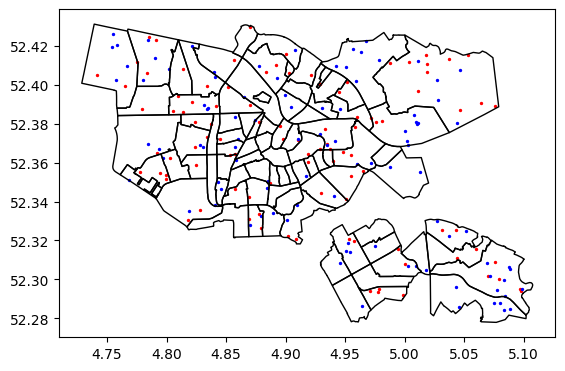

In [140]:
fig, ax = plt.subplots()
points = Fake.sample(100).start
xs = [point.x for point in points]
ys = [point.y for point in points]
ax.scatter(xs, ys, color = 'red', s = 2)

points = Fake.sample(100).end
xs = [point.x for point in points]
ys = [point.y for point in points]
ax.scatter(xs, ys, color = 'blue', s = 2)

# p = gpd.GeoSeries(combined_multi_polygon)
# p.plot(ax = ax, facecolor = 'None')
PCs.plot(ax = ax, facecolor = 'None')
plt.show()


ax.set_aspect('equal')


In [143]:
Fake = Fake.drop(['start','end'], axis=1, inplace = True)

KeyError: "['start', 'end'] not found in axis"

In [145]:
FakeFelyxDF = pd.concat([Real, Fake], axis = 0)
FakeFelyxDF.dtypes
FakeFelyxDF

,aankpc,hour,weekday,vertpc,Real
0,1105.0,21,4,1102.0,1
1,1053.0,16,2,1018.0,1
2,1012.0,12,0,1016.0,1
3,1072.0,18,3,1078.0,1
4,1055.0,23,5,1043.0,1
...,...,...,...,...,...
99995,1041,14,6,1081,0
99996,1066,10,5,1096,0
99997,1028,11,1,1108,0
99998,1067,13,5,1027,0


In [146]:
FakeFelyxDF.to_pickle('FakeFelyxData')